In [ ]:
from getpass import getpass

admin_rdm_url = 'https://admin.bh.rdm.yzwlab.com/' #'https://admin.staging.rdm.example.com/'
idp_name_1 = None # 'GakuNin RDM IdP'
idp_username_1 = None
idp_password_1 = None
default_result_path = None
close_on_fail = False
transition_timeout = 30000

# 検索用Registration情報
search_registration_id = 'y9cbd'
search_registration_title = 'test-metadata'

In [2]:
if idp_username_1 is None:
    idp_username_1 = input(prompt=f'Username for {idp_name_1}')
if idp_password_1 is None:
    idp_password_1 = getpass(prompt=f'Password for {idp_username_1}@{idp_name_1}')
(len(idp_username_1), len(idp_password_1))

(7, 16)

# 定期監視-管理者-RDM登録

- サブシステム名: 管理者
- ページ/アドオン: 管理者
- 機能分類: ログイン
- シナリオ名: ログイン確認
- 用意するテストデータ: URL一覧、アカウント(管理者ユーザー1: GRDM)


## GakuNin RDM管理者ページのURLを開く

①ブラウザを開き、画面右上の設定メニューから「シークレットモードで開く」を選択する。  
②新規画面が開かれ、画面上において、「シークレットモードです」と表示されていることを確認する。
以下、シークレットモードにて確認を行う。


In [3]:
import tempfile

work_dir = tempfile.mkdtemp()
if default_result_path is None:
    default_result_path = work_dir
work_dir

'/tmp/tmp8wmrqdj9'

In [4]:
import importlib
import pandas as pd

import scripts.playwright
importlib.reload(scripts.playwright)

from scripts.playwright import *
from scripts import grdm

await init_pw_context(close_on_fail=close_on_fail, last_path=default_result_path)

('20251117-064824', '/tmp/tmpf5ana7mj')

Start epoch: 1763362105.122188 seconds


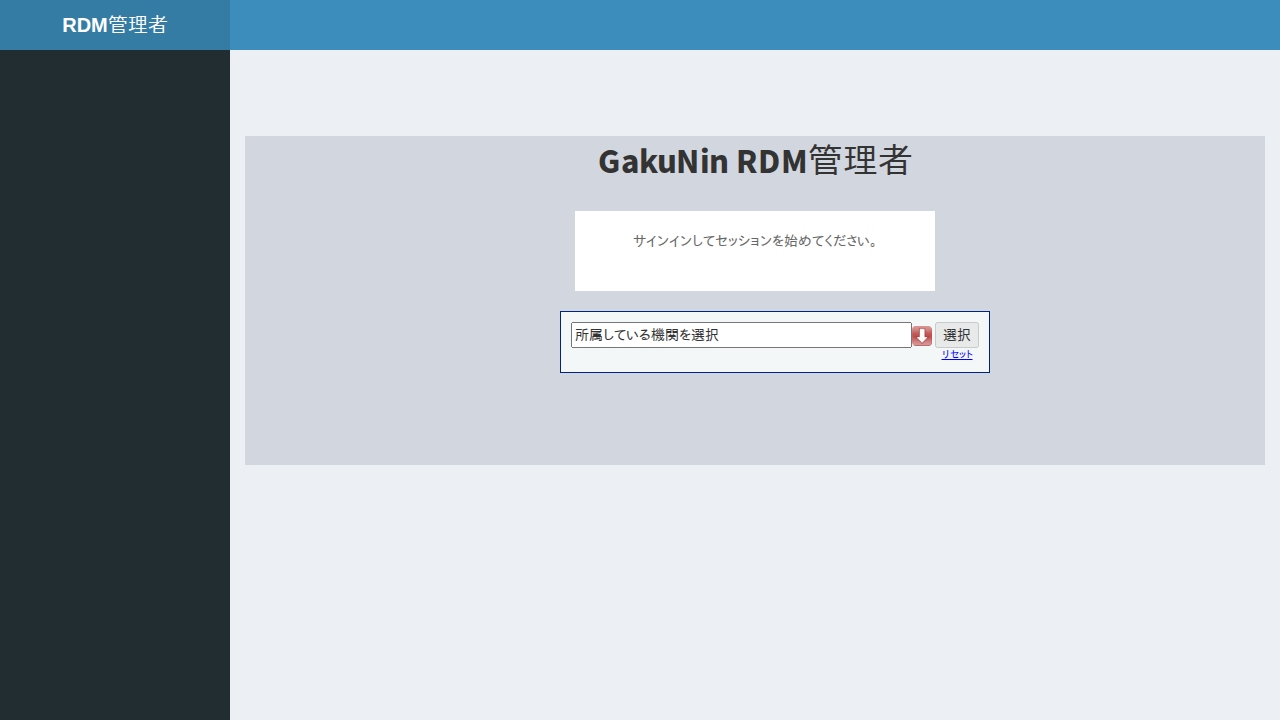

In [5]:
import time

async def _step(page):
    await page.goto(admin_rdm_url)

    await expect(page.locator('.login-logo')).to_be_visible(timeout=30000)

await run_pw(_step)

## ログイン情報を用いてGakuNin RDMにログインする

(IdPに関するログイン情報が与えられた場合、)
GakuNin Embeded DSのプルダウンを展開し、IdPリストから指定されたIdPを選択する。その後、アカウントのID/Passwordを入力して「Login」ボタンを押下する。

(IdPが指定されていない場合、)
CASのログイン操作を実施する。

Start epoch: 1763362107.1121902 seconds
ierae08
YibkH0U9-3^%Z@v8


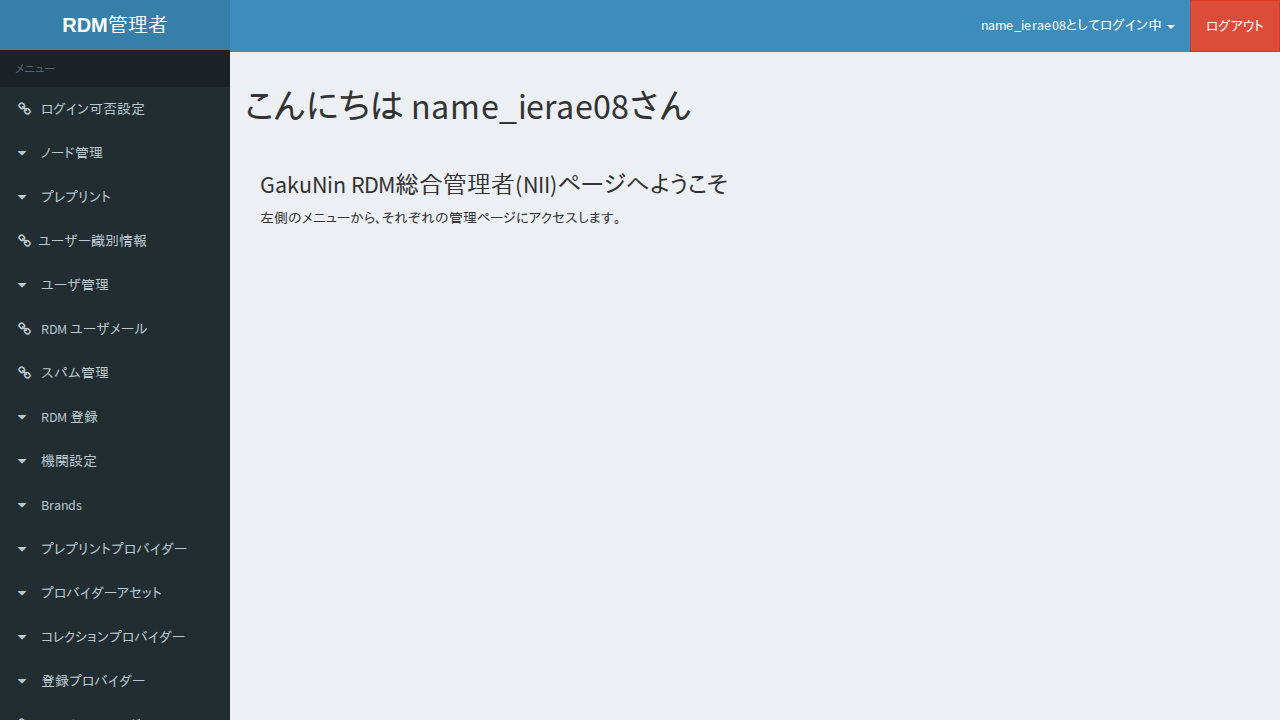

In [6]:
import scripts.grdm
importlib.reload(scripts.grdm)

async def _step(page):
    await scripts.grdm.login_as_admin(
        page, idp_name_1, idp_username_1, idp_password_1, transition_timeout=transition_timeout
    )

    await expect(page.locator('//*[contains(@class, "btn-danger") and contains(text(), "ログアウト")]')).to_be_enabled(timeout=transition_timeout)

await run_pw(_step)

## 「RDM 登録」から「全ての登録」を選択する

「List of Registrations」が表示される

Start epoch: 1763362114.354563 seconds


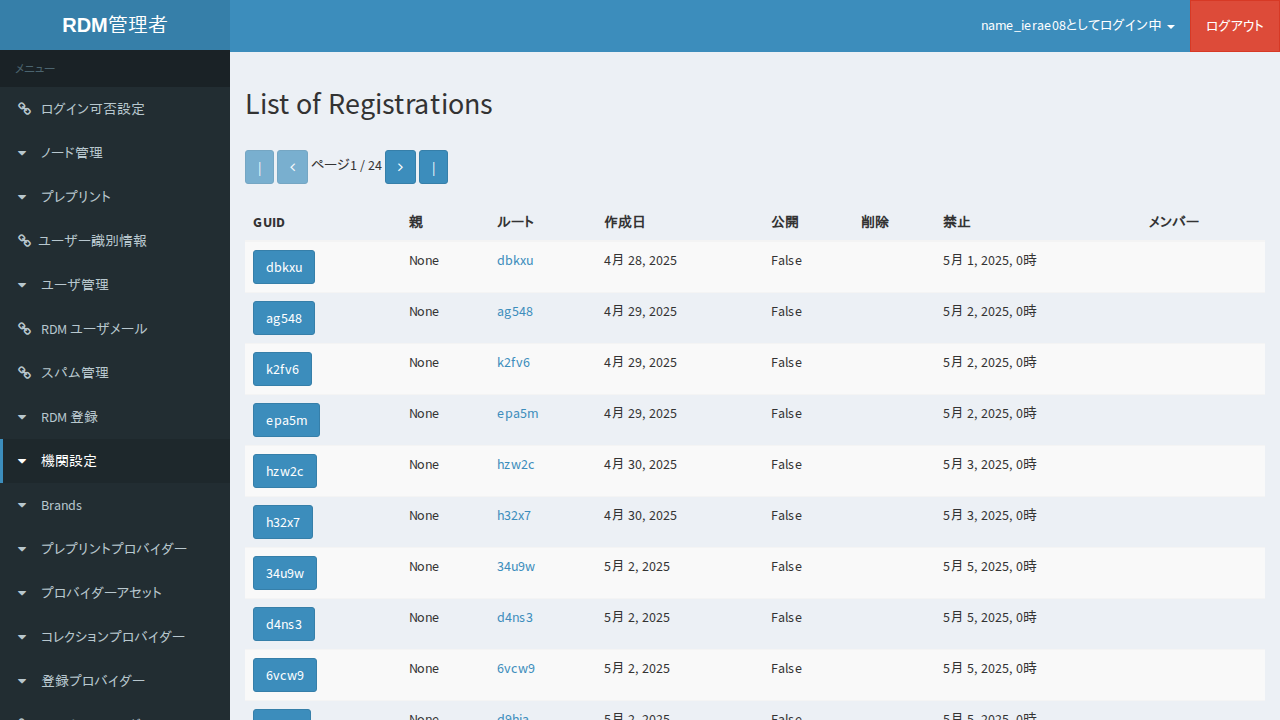

In [7]:
async def _step(page):
    await page.locator('//a[@href = "#collapseRegistrations"]').click()
    await page.locator('//a[@href = "/nodes/registration_list/"]').click()

    await expect(page.locator('//h2[text() = "List of Registrations"]')).to_be_visible(timeout=transition_timeout * 5)

await run_pw(_step)

## 「List of Registrations」画面の、GUID欄にある(指定されたGUID)を押下する

「登録の詳細」が表示される

Start epoch: 1763362115.9758103 seconds


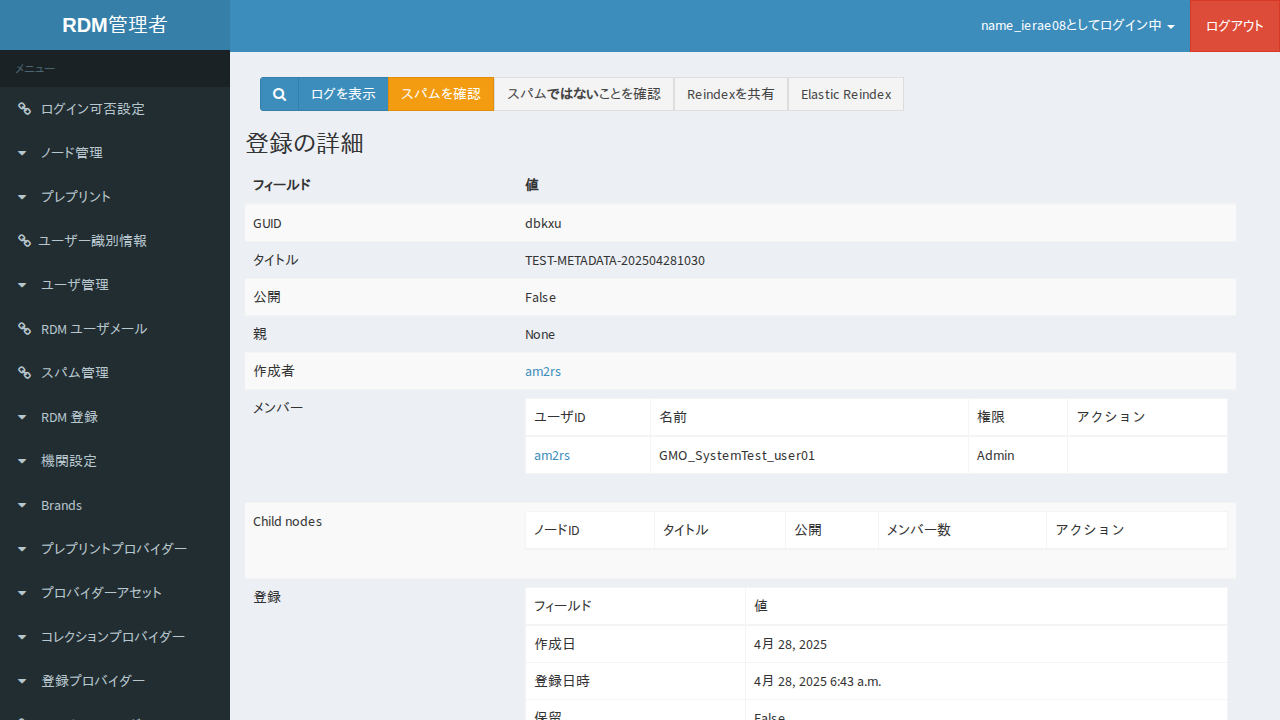

In [8]:
import traceback

async def _step(page):
    while True:
        link = page.locator(f'//a[contains(@class, "btn-primary") and contains(text(), "{search_registration_id}")]')
        try:
            await expect(link).to_be_visible()
        except:
            traceback.print_exc()
            print('Search next page...')
            # 次のページかもしれない
            await page.locator('//a[i[contains(@class, "fa-angle-right")]]').click()
            await expect(page.locator('//h2[text() = "List of Registrations"]')).to_be_visible(timeout=transition_timeout)
            continue
        await link.click()
        break

    await expect(page.locator(f'//td[text() = "{search_registration_title}"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「ログを表示」ボタンを押下する

ログの詳細（日付、アクション、ユーザ、パラメータ）が表示される

Start epoch: 1763362116.5935597 seconds


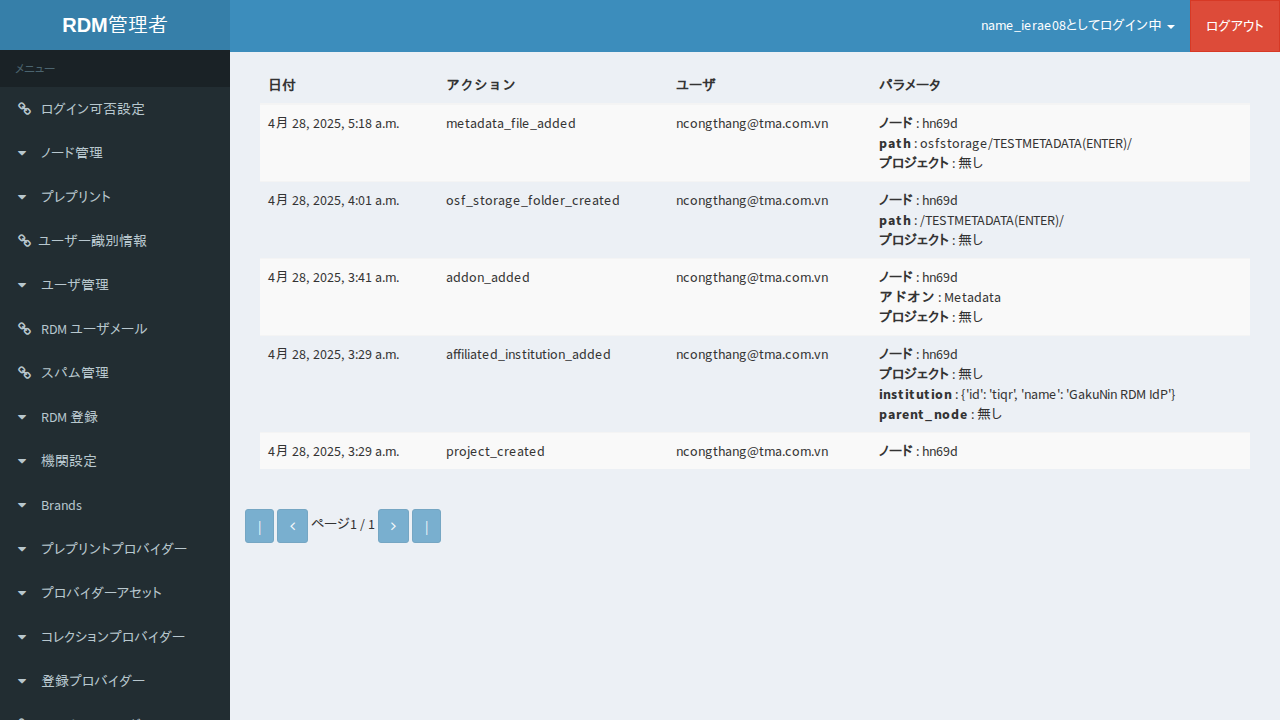

In [9]:
async def _step(page):
    await page.locator('//a[text() = "ログを表示"]').click()

    await expect(page.locator(f'//th[contains(text(), "アクション")]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「RDM 登録」から「スタックされた登録」を選択する

「List of Registrations」が表示される

Start epoch: 1763362117.0963843 seconds


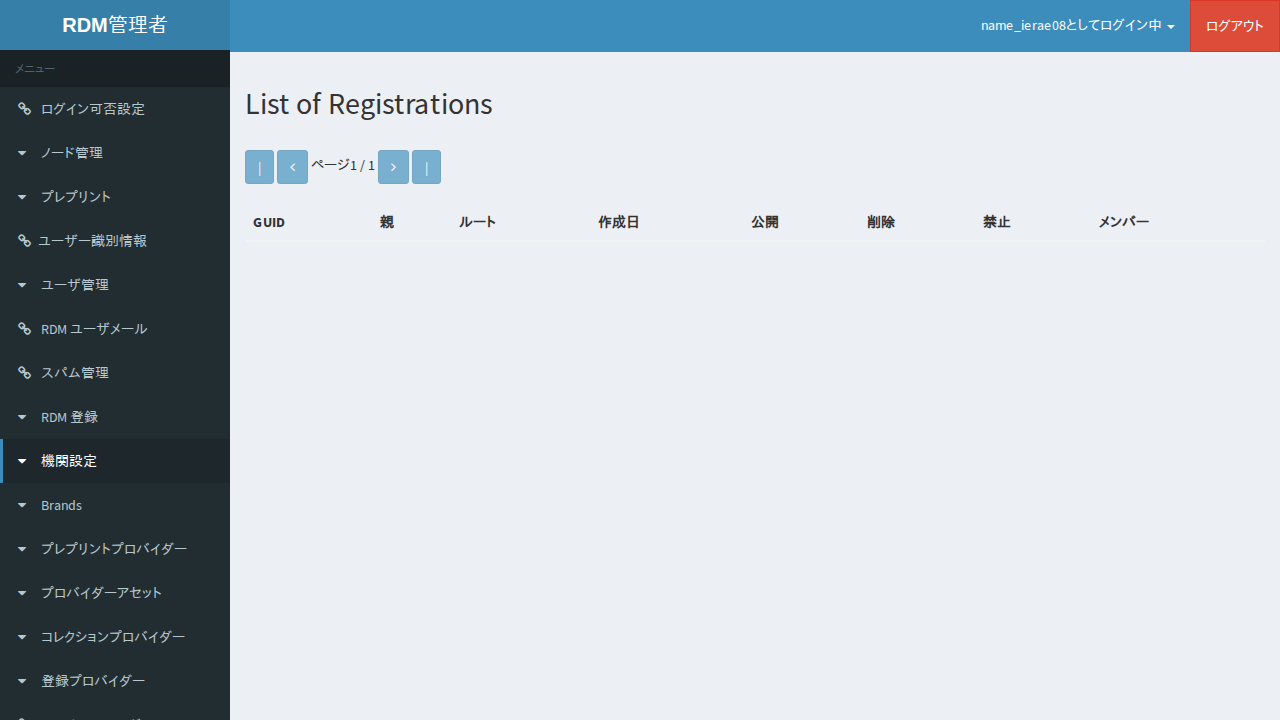

In [10]:
async def _step(page):
    await page.locator('//a[@href = "#collapseRegistrations"]').click()
    await page.locator('//a[@href = "/nodes/stuck_registration_list/"]').click()

    await expect(page.locator('//h2[text() = "List of Registrations"]')).to_be_visible(timeout=transition_timeout * 5)

await run_pw(_step)

## 「RDM 登録」から「e-Rad Records」を選択する

「e-Rad records」が表示される

Start epoch: 1763362117.5539799 seconds


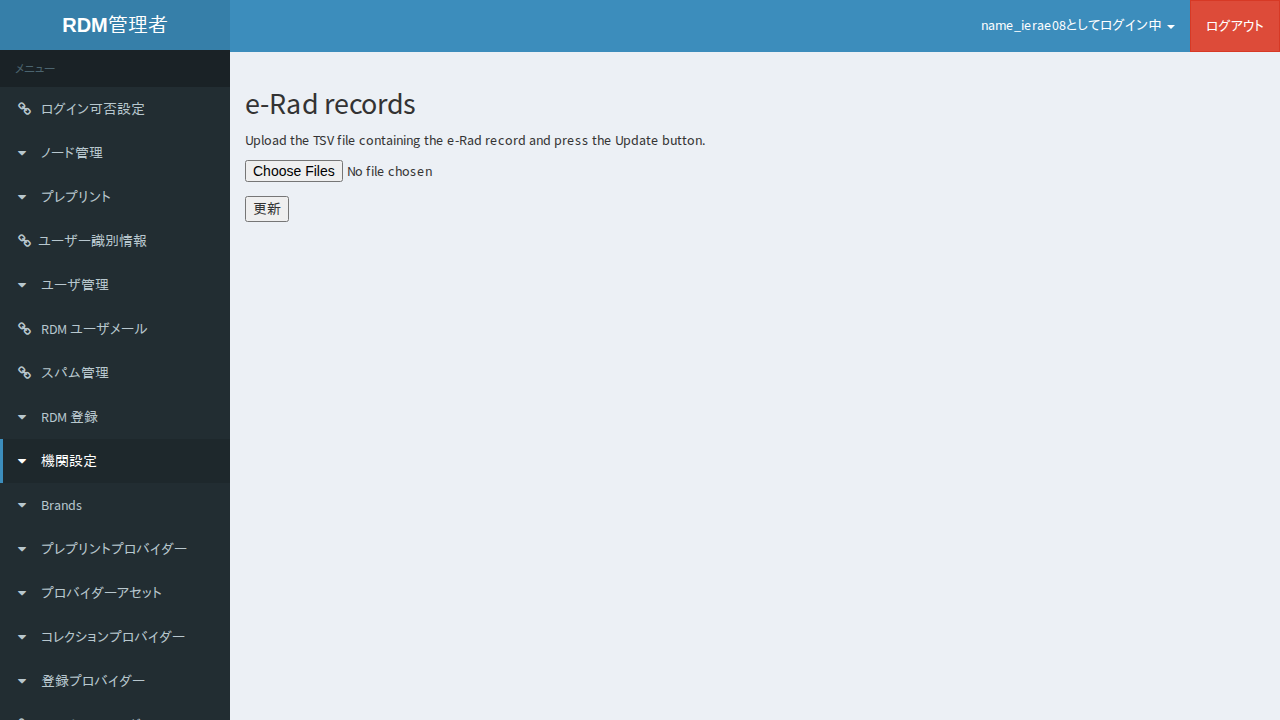

In [11]:
async def _step(page):
    await page.locator('//a[@href = "#collapseRegistrations"]').click()
    await page.locator('//a[@href = "/metadata/erad"]').click()

    await expect(page.locator('//h2[text() = "e-Rad records"]')).to_be_visible(timeout=transition_timeout)

await run_pw(_step)

## 「ファイル選択」からアップロードするファイルを選択する

選択したファイル名が表示される

Start epoch: 1763362118.1848261 seconds


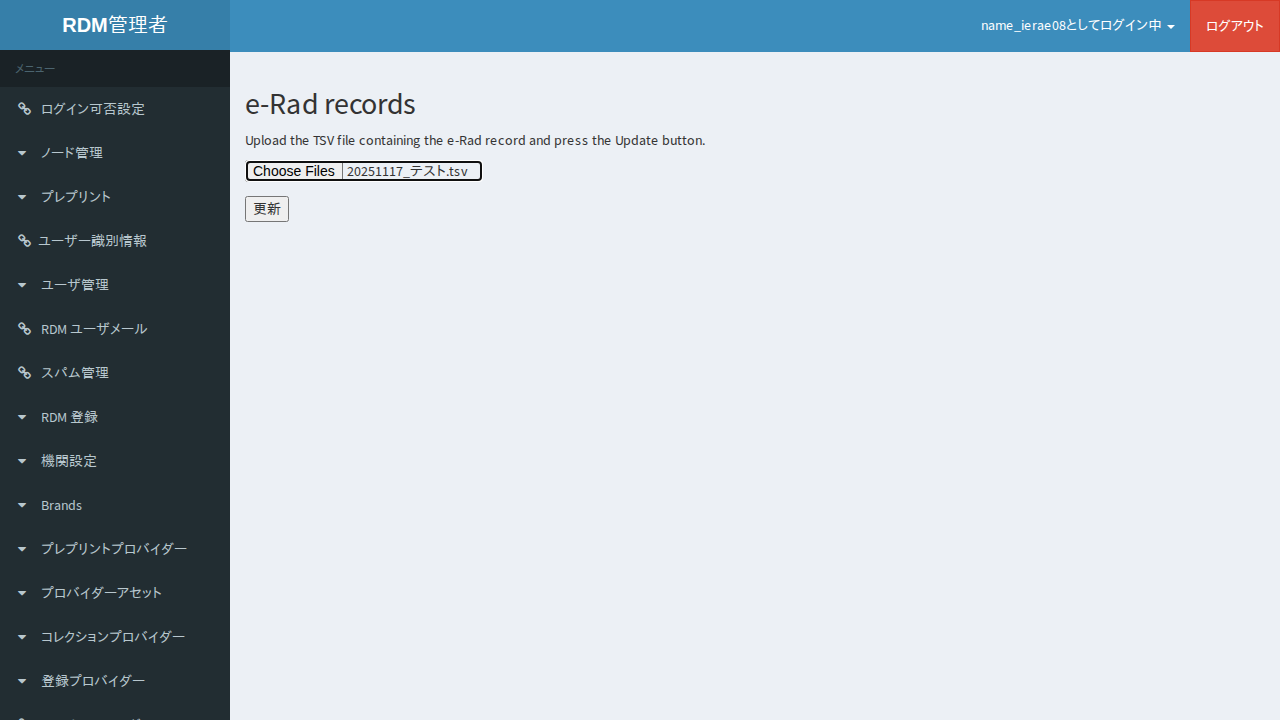

In [12]:
import traceback
from datetime import datetime

# ファイルの作成
yyyymmdd = datetime.now().strftime('%Y%m%d')
filename = f'{yyyymmdd}_テスト.tsv'
filepath = os.path.join(work_dir, filename)

with open(filepath, 'w', encoding='utf-8') as f:
    for i in range(100):
        f.write("x\tx\tx\n")

async def _step(page):
    await expect(page.locator('//input[@type = "file"]')).to_be_enabled(timeout=transition_timeout)
    await page.locator('//input[@type = "file"]').click()
    await page.set_input_files('//input[@type = "file"]', filepath)
    time.sleep(2)

await run_pw(_step)

終了処理を実施。

In [13]:
await finish_pw_context()

Video: result/result-20251117-041029/取りまとめ-管理者機能/notebooks/テスト手順-管理者機能-RDM登録/video-1.webm
HAR: result/result-20251117-041029/取りまとめ-管理者機能/notebooks/テスト手順-管理者機能-RDM登録/har.zip


スクリーンキャプチャ動画の取得に失敗しました。
Traceback (most recent call last):
  File "/home/jovyan/scripts/playwright.py", line 168, in _finish_pw_context
    shutil.copyfile(video_path, dest_video_path)
  File "/opt/conda/lib/python3.12/shutil.py", line 260, in copyfile
    with open(src, 'rb') as fsrc:
         ^^^^^^^^^^^^^^^
FileNotFoundError: [Errno 2] No such file or directory: '/tmp/tmpf5ana7mj/videos/792483b263cc49bda4c11c3e46e86c21.webm'


In [14]:
!rm -fr {work_dir}